In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [13]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data, y.data

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

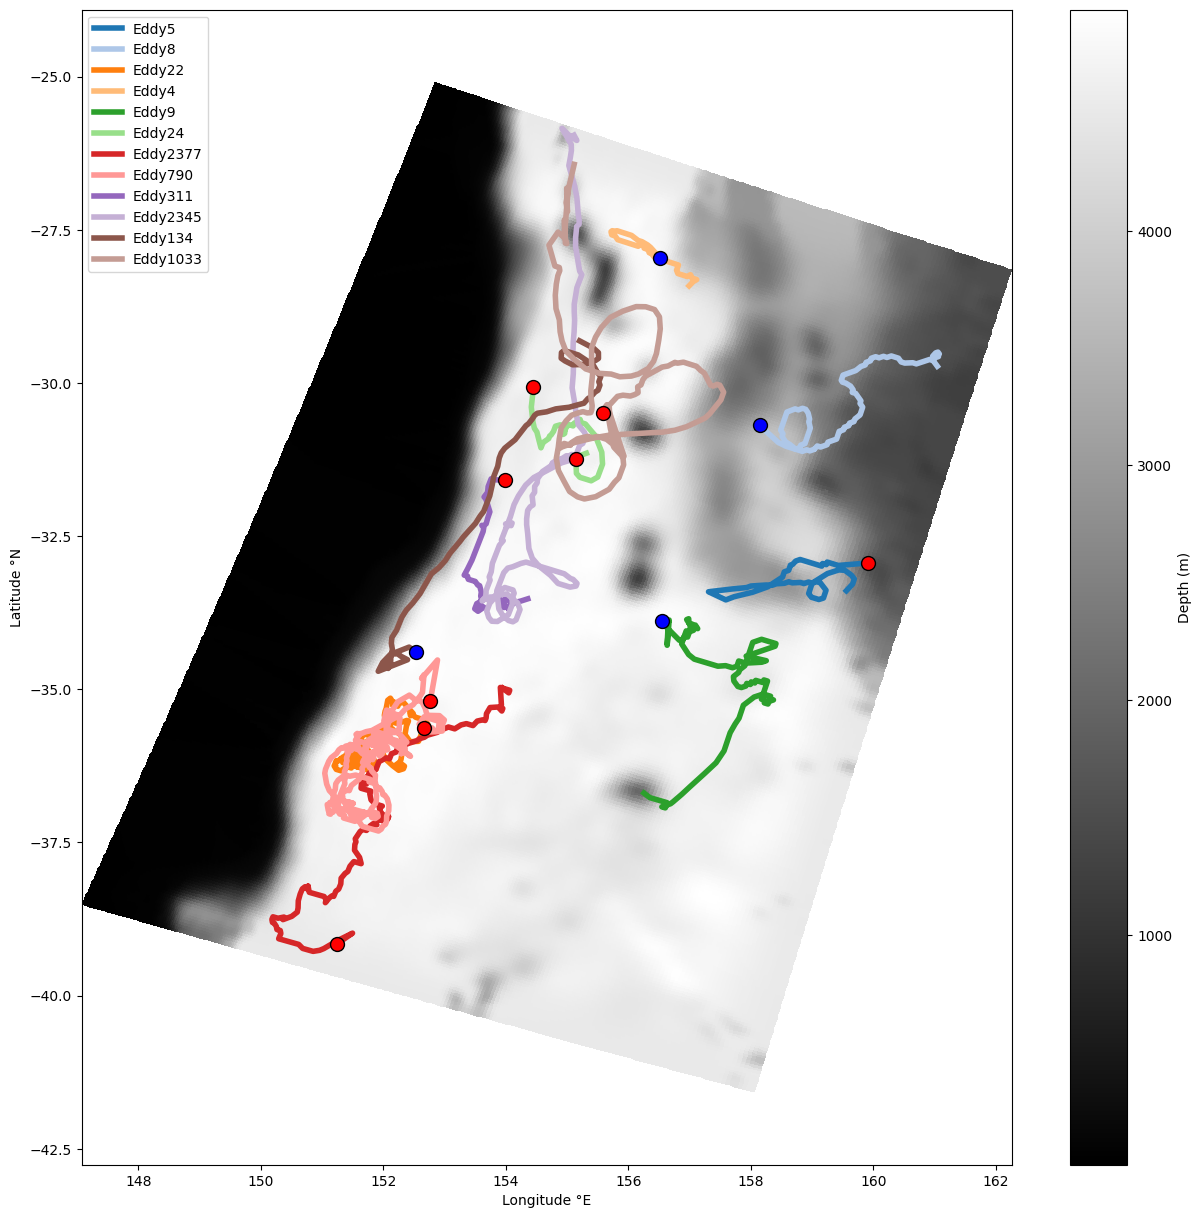

In [4]:
sample_eddies = ['Eddy5', 'Eddy8', 'Eddy22', 'Eddy4', 'Eddy9', 'Eddy24', 'Eddy2377', 'Eddy790', 'Eddy311', 'Eddy2345', 'Eddy134', 'Eddy1033']

colors = plt.get_cmap('tab20')

plt.figure(figsize=(15, 15))

plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

for i, e in enumerate(sample_eddies):
    eddy_data = eddies[e]
    
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e, linewidth=4)
    
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=100, zorder=5)

# plt.xlim([148, 161])
plt.axis('equal')

plt.legend(loc='upper left')
plt.show()

In [77]:
def extract_velocity(eddy_name, eddies):
    edata = eddies[eddy_name]
    
    # Extract middle 30 days
    middle_index = edata.shape[0] // 2
    t0 = extract_number(edata.iloc[middle_index - 15].name) 
    tN = extract_number(edata.iloc[middle_index + 15].name) 
    
    # Initialize arrays
    U1 = np.zeros((lon_rho.shape[0], lon_rho.shape[1], z_r.shape[-1], tN - t0))
    V1 = np.zeros_like(U1)
    
    # Calculate time moduli and file indices
    t_mod0, t_modN = t0 % 30, tN % 30
    file_idx0, file_idxN = int(t0 // 30), int(tN // 30)
    t_pres = 30 - t_mod0
    
    for file_idx in range(file_idx0, file_idxN + 1):
        fnumber = str(f"{1461 + file_idx * 30:05d}")
        
        # Calculate start and end indices
        start_idx = t_mod0 if file_idx == file_idx0 else 0
        end_idx = t_modN if file_idx == file_idxN else 30
        
        # Load data from the file
        U_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        V_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        
        # Fill data into arrays
        if file_idx == file_idx0:
            U1[:, :, :, :t_pres] = U_chunk
            V1[:, :, :, :t_pres] = V_chunk
        elif file_idx == file_idxN:
            U1[:, :, :, t_pres:] = U_chunk
            V1[:, :, :, t_pres:] = V_chunk
        else:
            U1[:, :, :, t_pres:(t_pres + 30)] = U_chunk
            V1[:, :, :, t_pres:(t_pres + 30)] = V_chunk
            t_pres += 30
    
    # Set invalid data to NaN
    U1 = np.where(np.abs(U1) > 1e30, np.nan, U1)
    V1 = np.where(np.abs(V1) > 1e30, np.nan, V1)
    
    return U1, V1

def interpolate_to_dx_spacing(x, y, Z, dx):
    # Define x and y ranges based on dx
    x_min, x_max = np.round(np.array([np.min(x), np.max(x)]) / dx) * dx
    y_min, y_max = np.round(np.array([np.min(y), np.max(y)]) / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)
    
    # Create the new interpolated Z array with shape (len(y_new), len(x_new), depth_levels)
    depth_levels = Z.shape[2]
    Z_new = np.zeros((len(y_new), len(x_new), depth_levels))
    
    # Interpolate at each depth level
    for k in range(depth_levels):
        original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        values = Z[:, :, k].flatten()
        new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
        
        Z_new[:, :, k] = griddata(original_points, values, new_points, method='linear').reshape(len(y_new), len(x_new))
    
    return x_new, y_new, Z_new

def chunk_interpolator(t, U1, V1):

    t0 = eddies[sample_eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[sample_eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    
    i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
    x_roms, y_roms = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

    _, _, U = interpolate_to_dx_spacing(x_roms, y_roms, U1[i_left:i_right, j_down:j_up,:DEPTH_LVL_LIMIT,t], dx)
    x, y, V = interpolate_to_dx_spacing(x_roms, y_roms, V1[i_left:i_right, j_down:j_up,:DEPTH_LVL_LIMIT,t], dx)

    return {'U': U, 'V': V, 'x': x, 'y': y}

SEARCH_WIDTH = 300000
DEPTH_LVL_LIMIT = 23
dx = 3000

for sample_eddy = ['Eddy22']

    U1, V1 = extract_velocity(sample_eddy, eddies)
    
    sample_data = {sample_eddy: {f'T{t}': chunk_interpolator(t, U1, V1) for t in range(U1.shape[-1])}}

In [73]:
# with open('/srv/scratch/z5297792/Sample/sample_data_CE8.pkl', 'wb') as file:
#     pickle.dump(sample_data, file)

In [78]:
V = sample_data[sample_eddy]['T10']['V']
U = sample_data[sample_eddy]['T10']['U']
x = sample_data[sample_eddy]['T10']['x']
y = sample_data[sample_eddy]['T10']['y']

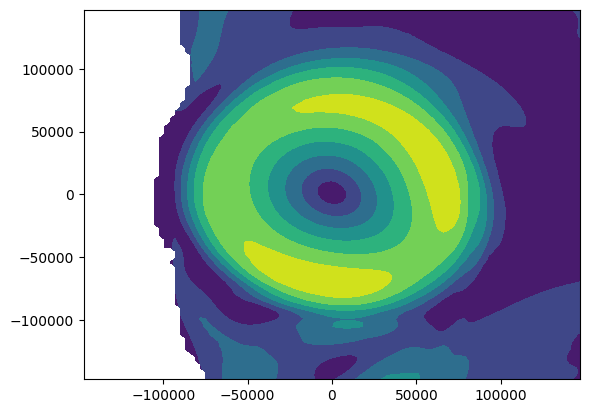

In [79]:
d_level = 10
plt.contourf(x,y,np.sqrt(U[:,:,d_level]**2+V[:,:,d_level]**2).T)